In [2]:
%matplotlib inline

import os
import scipy
import pandas as pd
import matplotlib
import itertools
import collections
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

PODS_DIR = "/Volumes/WorkDrive/msbayes-buffering/hickerlab-repository/msbayes-buffering/data/pods/msbuff_results/"
MODELS = ["0.01", "0.05", "0.1", "nobuffer"]

SAMEBUFFER_DIR = PODS_DIR + "samebufferPrior_PODS_results/"
UNBUFFEREDPODS_DIR = PODS_DIR + "bufferedPrior_unbufferedPODS_results/"
UNBUFFEREDPRIOR_DIR = PODS_DIR + "unbufferedPrior_bufferedPODS_results/"
UNSORTED_DIR = PODS_DIR + "unsorted_samebufferPrior_PODS_results/"

SAMEBUFFER_DIRS = [SAMEBUFFER_DIR + x for x in MODELS]
UNBUFFEREDPODS_DIRS = [UNBUFFEREDPODS_DIR + x for x in MODELS]
UNBUFFEREDPRIOR_DIRS = [UNBUFFEREDPRIOR_DIR + x for x in MODELS]
UNSORTED_DIRS = [UNSORTED_DIR + x for x in MODELS]


In [3]:
def calc_ttests(OUTDIRS, xcol, ycol, title):
    ## Set differences for psi vs omega
    print(title)
    if xcol == 0:
        param = "Psi"
    else:
        param = "Omega"

    data_dict = {}
    for RESULTS_DIR in OUTDIRS:
        RUN_NAME = RESULTS_DIR.split("/")[-1]

        df = pd.read_csv(RESULTS_DIR + "/results_psi_omega_et_tol.out", sep=" ", header=None)

        x = df[xcol]
        y = df[ycol]
        err=scipy.sqrt((x-y)**2)/float(len(x))
        data_dict[RUN_NAME] = err
    for names in itertools.combinations(data_dict.keys(), 2):
        print(names),
        print(scipy.stats.ttest_ind(data_dict[names[0]], data_dict[names[1]])[1])

In [4]:
def calc_fstats(OUTDIRS, xcol, ycol, title, fstat_df):
    ## Set differences for psi vs omega
    ## The row and col values here are for adding data to the right part of the df
    print(title)
    if xcol == 0:
        param = "Psi"
        row = 0
        col = 1
    else:
        param = "Omega"
        row = 1
        col = 0
    data_dict = {}
    for RESULTS_DIR in OUTDIRS:
        RUN_NAME = RESULTS_DIR.split("/")[-1]

        df = pd.read_csv(RESULTS_DIR + "/results_psi_omega_et_tol.out", sep=" ", header=None)

        x = df[xcol]
        y = df[ycol]
        err=scipy.sqrt((x-y)**2)/float(len(x))
        data_dict[RUN_NAME] = err
    for names in itertools.combinations(data_dict.keys(), 2):
        # The bad way
        #df1 = df2 = len(data_dict[names[0]])
        #alpha = 0.06 #Or whatever you want your alpha to be.
        #F = data_dict[names[0]].var() / data_dict[names[1]].var()
        #p_value = scipy.stats.f.sf(F, df1, df2)

        stat, p_value = scipy.stats.levene(data_dict[names[0]], data_dict[names[1]], center="mean")
        fstat_df[names[row]][names[col]] = (stat, p_value)
        print(names, stat, p_value)
    return fstat_df


In [5]:
def plot2x2(OUTDIRS, xcol, ycol, xlim, ylim, title):
    f, axarr = plt.subplots(2, 2, figsize=(8,4), dpi=1000)
    axarr = [a for b in axarr for a in b]

    ## Set differences for psi vs omega
    if xcol == 0:
        param = "Psi"
        xmin = 1
        ymin = 1
        def jitter(arr):
            stdev = .01*(max(arr)-min(arr))
            return arr + np.random.randn(len(arr)) * stdev
    else:
        param = "Omega"
        xmin = 0
        ymin = 0
        def jitter(arr):
            return arr
        
    for RESULTS_DIR, ax in zip(OUTDIRS, axarr):
        RUN_NAME = RESULTS_DIR.split("/")[-1]

        print (RUN_NAME),
        df = pd.read_csv(RESULTS_DIR + "/results_psi_omega_et_tol.out", sep=" ", header=None)

        x = df[xcol]
        y = df[ycol]
        
        ## linregress gets the rvalue and polyfit/poly1d gives us the fit function so we can draw the regression line
        res = linregress(x,y)
        fit = np.polyfit(x, y, 1)
        fit_fn = np.poly1d(fit)

        ## Calculate RMSE
        err=scipy.sqrt(sum((x-y)**2)/float(len(x)))
        RMSE = "RMSE {0:.4f}".format(err)
        R2 = "R^2  {0:.4f}".format(res.rvalue**2)
        #print(RMSE, R2)

        ## Plot the data and the regression line
        ax.scatter(jitter(x), jitter(y), marker="o", color='w', edgecolors='black')
        pts = np.linspace(xmin, xlim)
        ax.plot(pts, fit_fn(pts), '-r')

        ## Set titles and x/y limits
        ax.set_xlabel("True {}".format(param), fontsize=10)
        ax.set_ylabel("Estimated {}".format(param), fontsize=10)
        ax.set_title(RUN_NAME, fontsize=10)
        ax.set_xlim(xmin, xlim)
        ax.set_ylim(ymin, ylim)

        ## Plot the identity line
        ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

        ## Add RMSE and R^2 to plots
        ax.text(0.2, 0.9, RMSE, ha='center', va='center', transform=ax.transAxes, color='r', size=8)
        ax.text(0.2, 0.78, R2, ha='center', va='center', transform=ax.transAxes, color='r', size=8)

        ## Remove the stupid tick spines
        ax.tick_params(axis=u'both', which=u'both',length=0)

    ## Give a little space between plots
    plt.subplots_adjust(wspace=0.4, hspace=0.6)
    plt.suptitle(title, fontsize=13)


In [6]:
def plotRMSE(OUTDIRS, xcol, ycol, xlim, ylim, title):
    f, axarr = plt.subplots(2, 2, figsize=(8,4), dpi=1000)
    axarr = [a for b in axarr for a in b]

    ## Set differences for psi vs omega
    if xcol == 0:
        param = "Psi"
        xmin = 0
        ymin = 0
#        def jitter(arr):
#            stdev = .01*(max(arr)-min(arr))
#            return arr + np.random.randn(len(arr)) * stdev
        def jitter(arr):
            return arr
    else:
        param = "Omega"
        xmin = 0
        ymin = 0
        def jitter(arr):
            return arr
        
    for RESULTS_DIR, ax in zip(OUTDIRS, axarr):
        RUN_NAME = RESULTS_DIR.split("/")[-1]

        print (RUN_NAME),
        df = pd.read_csv(RESULTS_DIR + "/results_psi_omega_et_tol.out", sep=" ", header=None)

        x = df[xcol]
        y = df[ycol]
        
        ## Plot the data and the regression line
        ax.scatter(jitter(x), jitter(y), marker="o", color='w', edgecolors='black')

        ## Calculate and plot the mean RMSE
        RMSE = "Mean RMSE {0:.4f}".format(np.mean(y))
        ax.text(0.2, 0.9, RMSE, ha='center', va='center', transform=ax.transAxes, color='r', size=8)

        ## Set titles and x/y limits
        ax.set_xlabel("True {}".format(param), fontsize=10)
        ax.set_ylabel("RMSE est. {}".format(param), fontsize=10)
        ax.set_title(RUN_NAME, fontsize=10)
        ax.set_xlim(xmin, xlim)
        ax.set_ylim(ymin, ylim)

        ## Remove the stupid tick spines
        ax.tick_params(axis=u'both', which=u'both',length=0)

    ## Give a little space between plots
    plt.subplots_adjust(wspace=0.4, hspace=0.6)
    plt.suptitle(title, fontsize=13)


0.01 0.05 0.1 nobuffer 0.01 0.05 0.1 nobuffer


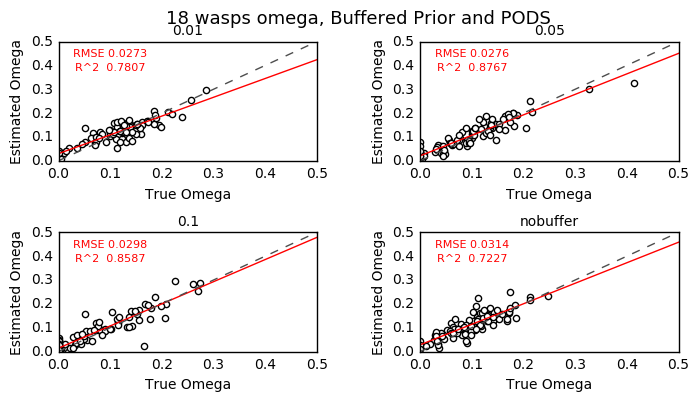

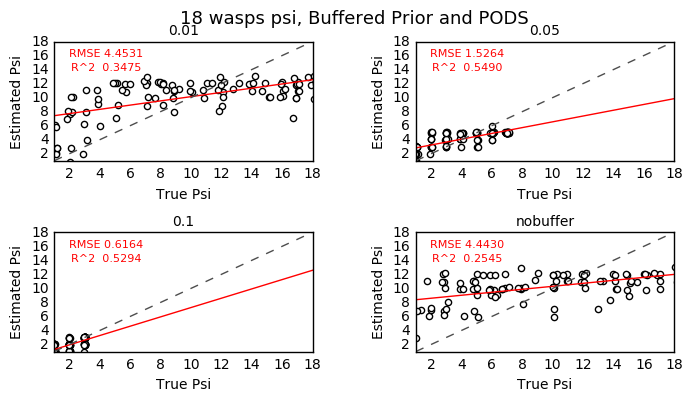

In [9]:
## Use column 6 to plot unadjusted omega values
#plot2x2(SAMEBUFFER_DIRS, 3, 6, 0.5, 0.5, "18 wasps omega (unadjusted), sort vs usort")
plot2x2(SAMEBUFFER_DIRS, 3, 4, 0.5, 0.5, "18 wasps omega, Buffered Prior and PODS")
plot2x2(SAMEBUFFER_DIRS, 0, 1, 18, 18, "18 wasps psi, Buffered Prior and PODS")

In [8]:
calc_ttests(SAMEBUFFER_DIRS, 3, 4, "18 wasps omega, Buffered Prior and PODS")
calc_ttests(SAMEBUFFER_DIRS, 0, 1, "18 wasps psi, Buffered Prior and PODS")

18 wasps omega, sort vs usort
('0.1', 'nobuffer') 0.14569023117
('0.1', '0.01') 0.743047601618
('0.1', '0.05') 0.633922529273
('nobuffer', '0.01') 0.196308286333
('nobuffer', '0.05') 0.255355125669
('0.01', '0.05') 0.865390710096
18 wasps psi, sort vs usort
('0.1', 'nobuffer') 6.44646233263e-34
('0.1', '0.01') 5.43139612405e-34
('0.1', '0.05') 2.36639469769e-18
('nobuffer', '0.01') 0.975309067072
('nobuffer', '0.05') 1.30852578485e-20
('0.01', '0.05') 1.07359488153e-20


0.01 0.05 0.1 nobuffer 0.01 0.05 0.1 nobuffer


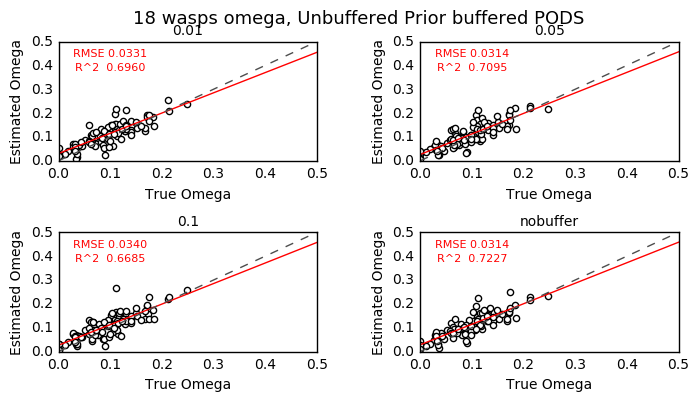

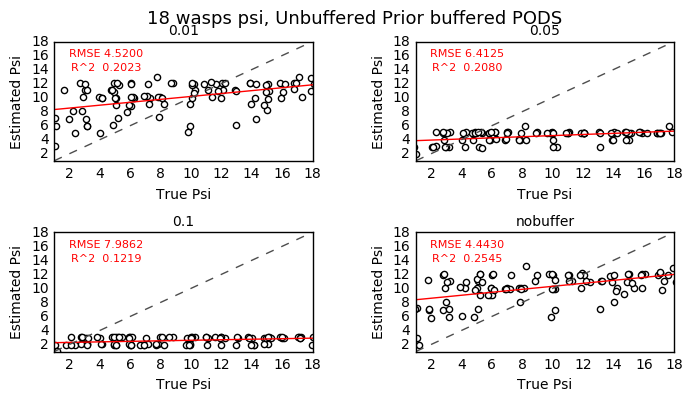

In [26]:
## Use column 6 to plot unadjusted omega values
#plot2x2(SAMEBUFFER_DIRS, 3, 6, 0.5, 0.5, "18 wasps omega (unadjusted), sort vs usort")
plot2x2(UNBUFFEREDPODS_DIRS, 3, 4, 0.5, 0.5, "18 wasps omega, Unbuffered Prior buffered PODS")
plot2x2(UNBUFFEREDPODS_DIRS, 0, 1, 18, 18, "18 wasps psi, Unbuffered Prior buffered PODS")

In [11]:
calc_ttests(UNBUFFEREDPODS_DIRS, 3, 4, "18 wasps, Unbuffered Prior buffered PODS")
calc_ttests(UNBUFFEREDPODS_DIRS, 0, 1, "18 wasps, Unbuffered Prior buffered PODS")

18 wasps, Buffered Prior unbuffered PODS
('0.1', 'nobuffer') 0.665544978559
('0.1', '0.01') 0.847527294881
('0.1', '0.05') 0.582757600074
('nobuffer', '0.01') 0.508687123017
('nobuffer', '0.05') 0.897316914164
('0.01', '0.05') 0.434374556162
18 wasps, Buffered Prior unbuffered PODS
('0.1', 'nobuffer') 1.06179925935e-06
('0.1', '0.01') 2.0821450767e-06
('0.1', '0.05') 0.0160297383817
('nobuffer', '0.01') 0.829597888102
('nobuffer', '0.05') 0.018105842928
('0.01', '0.05') 0.0270966267947


0.01 0.05 0.1 nobuffer 0.01 0.05 0.1 nobuffer


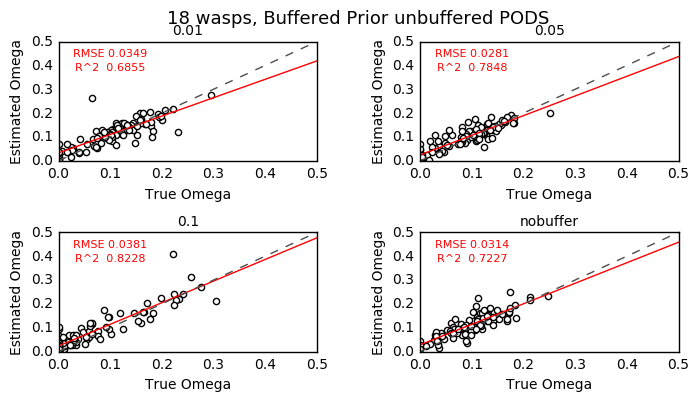

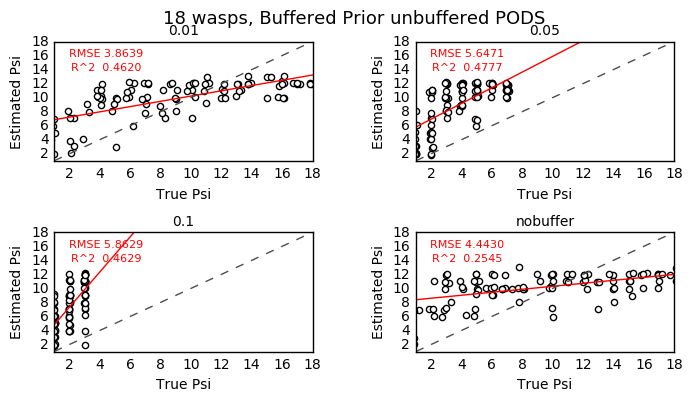

In [27]:
plot2x2(UNBUFFEREDPRIOR_DIRS, 3, 4, 0.5, 0.5, "18 wasps, Buffered Prior unbuffered PODS")
plot2x2(UNBUFFEREDPRIOR_DIRS, 0, 1, 18, 18, "18 wasps, Buffered Prior unbuffered PODS")

In [13]:
calc_ttests(UNBUFFEREDPRIOR_DIRS, 3, 4, "18 wasps, Buffered Prior unbuffered PODS")
calc_ttests(UNBUFFEREDPRIOR_DIRS, 0, 1, "18 wasps, Buffered Prior unbuffered PODS")

18 wasps, Unuffered Prior buffered PODS
('0.1', 'nobuffer') 0.527725789555
('0.1', '0.01') 0.370094870773
('0.1', '0.05') 0.0452745320852
('nobuffer', '0.01') 0.694762833769
('nobuffer', '0.05') 0.0900401316168
('0.01', '0.05') 0.290984441629
18 wasps, Unuffered Prior buffered PODS
('0.1', 'nobuffer') 1.19518259892e-05
('0.1', '0.01') 1.38545480467e-09
('0.1', '0.05') 0.58616482648
('nobuffer', '0.01') 0.0755703675462
('nobuffer', '0.05') 4.31023551924e-05
('0.01', '0.05') 3.84938419108e-09


0.01 0.05 0.1 nobuffer 0.01 0.05 0.1 nobuffer


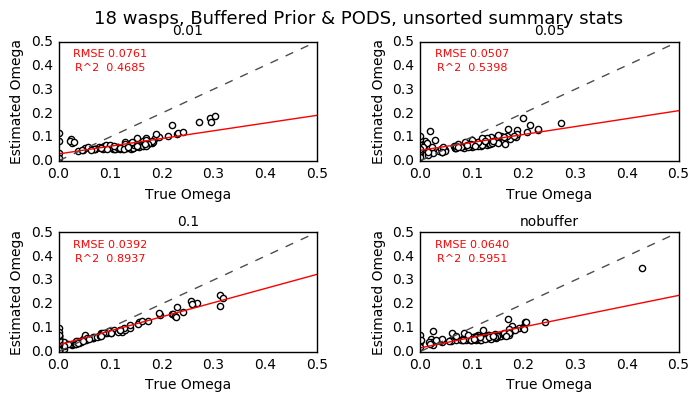

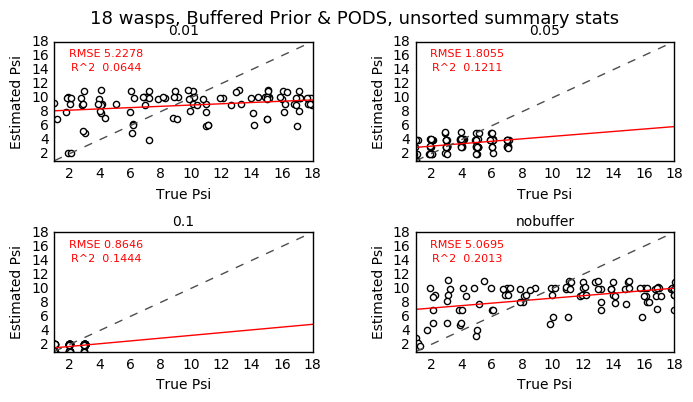

In [19]:
plot2x2(UNSORTED_DIRS, 3, 7, 0.5, 0.5, "18 wasps, Buffered Prior & PODS, unsorted summary stats")
plot2x2(UNSORTED_DIRS, 0, 1, 18, 18, "18 wasps, Buffered Prior & PODS, unsorted summary stats")

In [25]:
calc_ttests(UNSORTED_DIRS, 3, 4, "18 wasps, Unuffered Prior buffered PODS")
calc_ttests(UNSORTED_DIRS, 0, 1, "18 wasps, Unuffered Prior buffered PODS")

18 wasps, Unuffered Prior buffered PODS
('0.1', 'nobuffer') 0.316099142745
('0.1', '0.01') 0.316099142745
('0.1', '0.05') 0.316099142745
('nobuffer', '0.01') 0.318531037957
('nobuffer', '0.05') 0.318292563494
('0.01', '0.05') 0.318618984015
18 wasps, Unuffered Prior buffered PODS
('0.1', 'nobuffer') 2.54310994276e-25
('0.1', '0.01') 2.9864191219e-29
('0.1', '0.05') 8.93969577721e-07
('nobuffer', '0.01') 0.529393636894
('nobuffer', '0.05') 5.72460507355e-17
('0.01', '0.05') 3.78164393205e-20


0.01 0.05 0.1 nobuffer 0.01 0.05 0.1 nobuffer


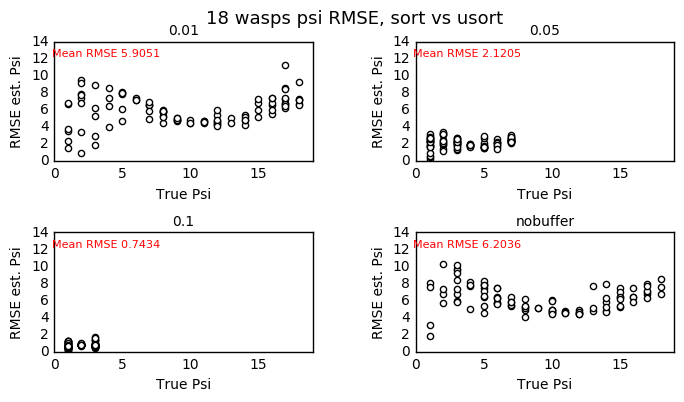

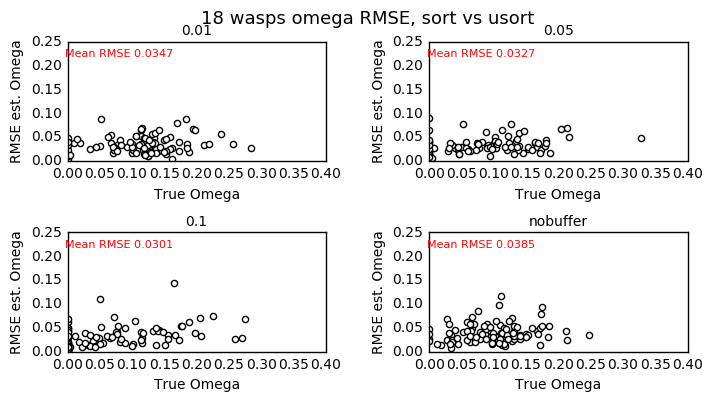

In [20]:
plotRMSE(SAMEBUFFER_DIRS, 0, 2, 19, 14, "18 wasps psi RMSE")
plotRMSE(SAMEBUFFER_DIRS, 3, 5, .4, .25, "18 wasps omega RMSE")

# Everything below here is crap

In [21]:
## For printing cells in tables bold if significant
def significant_bold(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    try:
        style = 'bold' if val[1] < 0.05 else 'normal'
    except:
        style = 'normal'
    return 'font-weight: %s' % style

In [24]:
## The printed dataframe is fucked up right now.
models = []
for RESULTS_DIR in SAMEBUFFER_DIRS:
    RUN_NAME = RESULTS_DIR.split("/")[-1]
    models.append(RUN_NAME)
df = pd.DataFrame(index=models, columns=models)
df = calc_fstats(SAMEBUFFER_DIRS, 3, 4, "18 omega, Buffered Prior and PODS", df)
df = calc_fstats(SAMEBUFFER_DIRS, 0, 1, "18 psi, Buffered Prior and PODS", df)
s = df.style.applymap(significant_bold)
s

18 omega, Buffered Prior and PODS
(('0.1', 'nobuffer'), 0.08565440467903461, 0.77008260169837328)
(('0.1', '0.01'), 0.54219656091229318, 0.46239531502636821)
(('0.1', '0.05'), 2.2930539242942825, 0.13154866485286923)
(('nobuffer', '0.01'), 0.22710919382969288, 0.63420114298810915)
(('nobuffer', '0.05'), 1.8560393048159802, 0.17463031857156139)
(('0.01', '0.05'), 1.0662364457637745, 0.30305668862163981)
18 psi, Buffered Prior and PODS
(('0.1', 'nobuffer'), 119.13495132232354, 5.1145924918679735e-22)
(('0.1', '0.01'), 170.58274620857969, 1.5876780012597192e-28)
(('0.1', '0.05'), 27.682979197035721, 3.6967765552509137e-07)
(('nobuffer', '0.01'), 0.29152782586535142, 0.58984985997017869)
(('nobuffer', '0.05'), 76.130221979553298, 1.0911925272992592e-15)
(('0.01', '0.05'), 109.52803949327138, 1.1032246861217014e-20)


fish_dirichlet_sort fish_dirichlet_usort fish_uniform_sort fish_uniform_usort fish_dirichlet_sort fish_dirichlet_usort fish_uniform_sort fish_uniform_usort


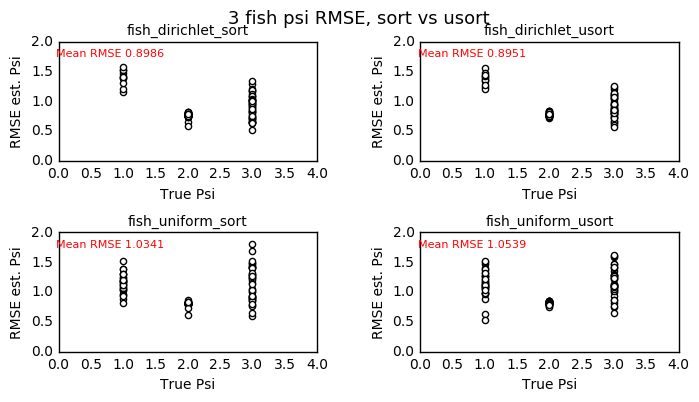

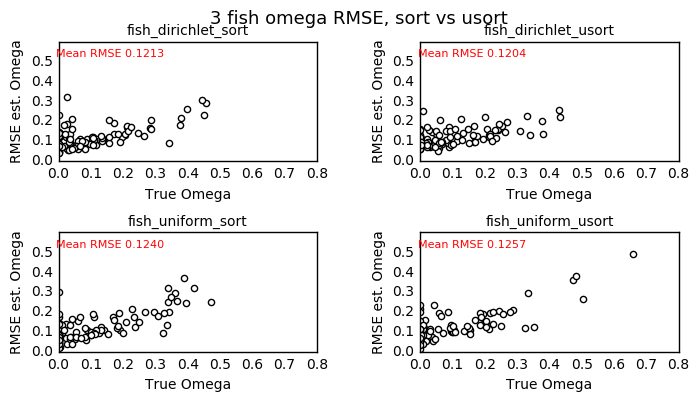

In [41]:
plotRMSE(FISH_OUTDIRS, 0, 2, 4, 2, "3 fish psi RMSE, sort vs usort")
plotRMSE(FISH_OUTDIRS, 3, 5, .8, .6, "3 fish omega RMSE, sort vs usort")

In [65]:
calc_fstats(FISH_OUTDIRS, 3, 4, "18 omega, sort vs usort")
calc_fstats(FISH_OUTDIRS, 0, 1, "18 psi, sort vs usort")

18 omega, sort vs usort
(('fish_dirichlet_usort', 'fish_uniform_sort'), 0.040177660034906582)
(('fish_dirichlet_usort', 'fish_uniform_usort'), 0.035428809489761896)
(('fish_dirichlet_usort', 'fish_dirichlet_sort'), 0.12515818757836156)
(('fish_uniform_sort', 'fish_uniform_usort'), 0.6936022397780327)
(('fish_uniform_sort', 'fish_dirichlet_sort'), 0.52171153837094419)
(('fish_uniform_usort', 'fish_dirichlet_sort'), 0.34344064493843529)
18 psi, sort vs usort
(('fish_dirichlet_usort', 'fish_uniform_sort'), 0.062731731927265)
(('fish_dirichlet_usort', 'fish_uniform_usort'), 0.0029193910180344909)
(('fish_dirichlet_usort', 'fish_dirichlet_sort'), 0.41942338759821096)
(('fish_uniform_sort', 'fish_uniform_usort'), 0.79166540848453693)
(('fish_uniform_sort', 'fish_dirichlet_sort'), 0.083077570851889132)
(('fish_uniform_usort', 'fish_dirichlet_sort'), 0.00458866652049565)


frogs_dirichlet_sort frogs_dirichlet_usort frogs_uniform_sort frogs_uniform_usort frogs_dirichlet_sort frogs_dirichlet_usort frogs_uniform_sort frogs_uniform_usort


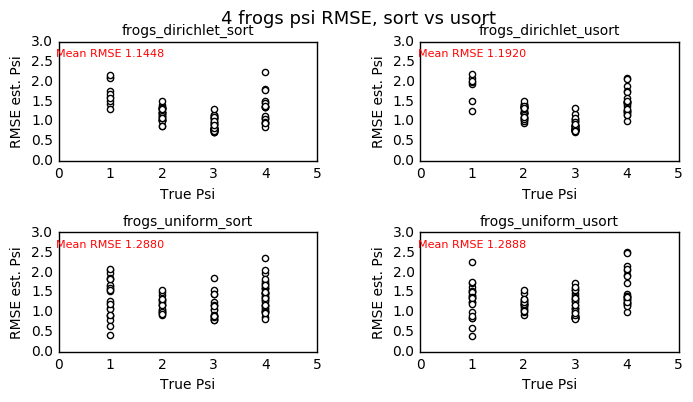

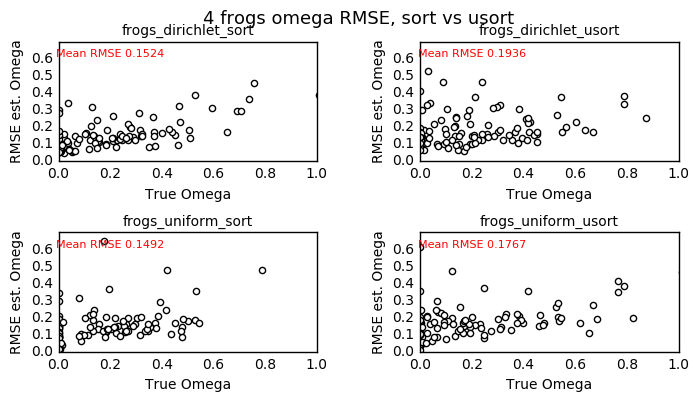

In [42]:
plotRMSE(FROG_OUTDIRS, 0, 2, 5, 3, "4 frogs psi RMSE, sort vs usort")
plotRMSE(FROG_OUTDIRS, 3, 5, 1, .7, "4 frogs omega RMSE, sort vs usort")

In [64]:
calc_fstats(FROG_OUTDIRS, 3, 4, "18 omega, sort vs usort")
calc_fstats(FROG_OUTDIRS, 0, 1, "18 psi, sort vs usort")

18 omega, sort vs usort
(('frogs_uniform_sort', 'frogs_dirichlet_usort'), 0.088440504903602418)
(('frogs_uniform_sort', 'frogs_dirichlet_sort'), 0.77627917713148065)
(('frogs_uniform_sort', 'frogs_uniform_usort'), 0.65733346209241472)
(('frogs_dirichlet_usort', 'frogs_dirichlet_sort'), 0.026089010039235489)
(('frogs_dirichlet_usort', 'frogs_uniform_usort'), 0.027787788168444443)
(('frogs_dirichlet_sort', 'frogs_uniform_usort'), 0.82541232637549222)
18 psi, sort vs usort
(('frogs_uniform_sort', 'frogs_dirichlet_usort'), 0.037850184937385553)
(('frogs_uniform_sort', 'frogs_dirichlet_sort'), 0.062971892818691519)
(('frogs_uniform_sort', 'frogs_uniform_usort'), 0.28645023626769917)
(('frogs_dirichlet_usort', 'frogs_dirichlet_sort'), 0.71499804650819154)
(('frogs_dirichlet_usort', 'frogs_uniform_usort'), 0.33624101700635922)
(('frogs_dirichlet_sort', 'frogs_uniform_usort'), 0.4958483737628645)


## Testing against the wrong prior
This is what happens when you use dpp pods with uniform prior and vice versa.

In [66]:
MODELS = ["dirichlet_sort", "dirichlet_usort", "uniform_sort", "uniform_usort"]
BAD_DIR = "/tmp/badPrior/"
FISH_BADDIRS = [BAD_DIR + "fish_" + x for x in MODELS]
FROG_BADDIRS = [BAD_DIR + "frogs_" + x for x in MODELS]

fish_dirichlet_sort fish_dirichlet_usort fish_uniform_sort fish_uniform_usort fish_dirichlet_sort fish_dirichlet_usort fish_uniform_sort fish_uniform_usort


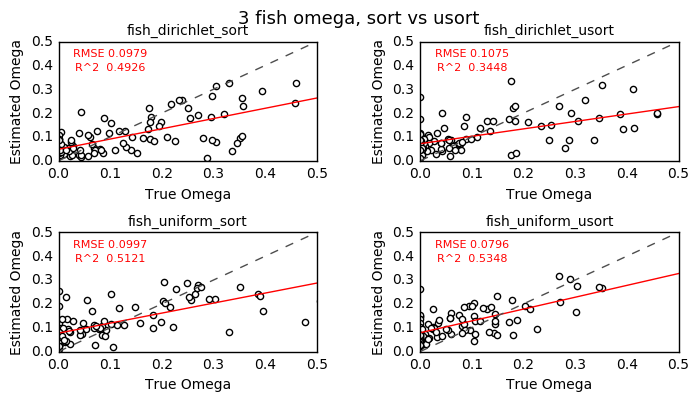

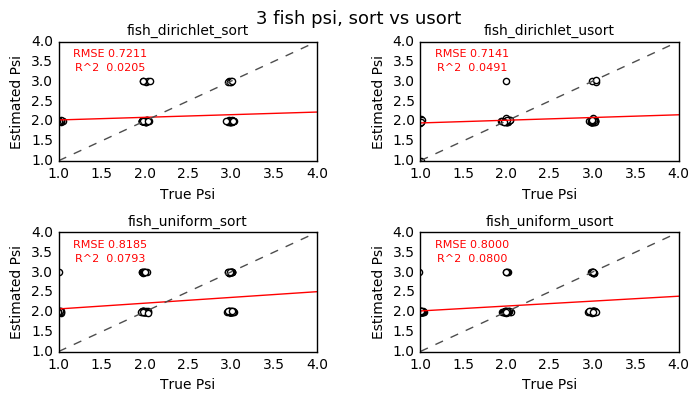

In [67]:
plot2x2(FISH_BADDIRS, 3, 4, 0.5, 0.5, "3 fish omega, sort vs usort")
plot2x2(FISH_BADDIRS, 0, 1, 4, 4, "3 fish psi, sort vs usort")

frogs_dirichlet_sort frogs_dirichlet_usort frogs_uniform_sort frogs_uniform_usort frogs_dirichlet_sort frogs_dirichlet_usort frogs_uniform_sort frogs_uniform_usort


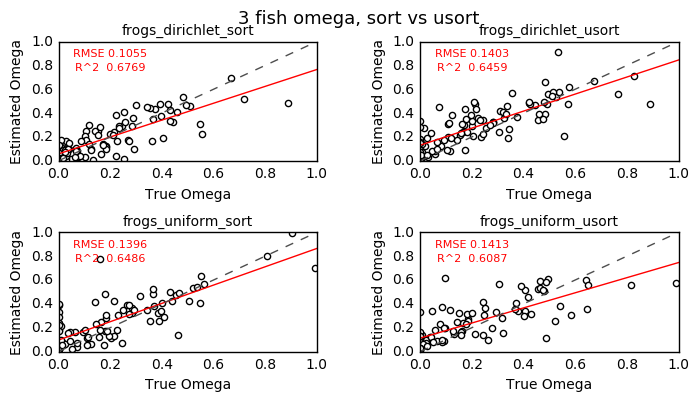

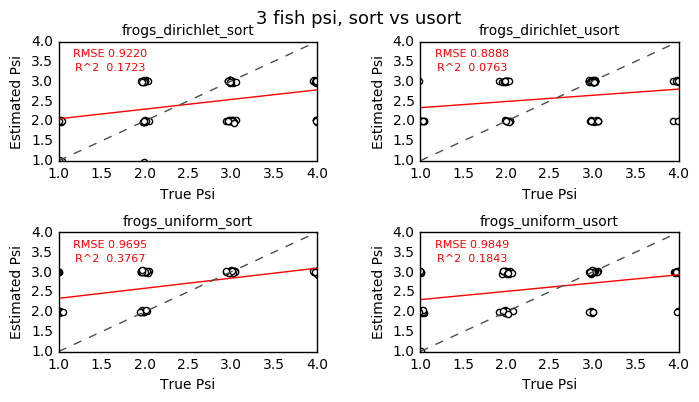

In [69]:
plot2x2(FROG_BADDIRS, 3, 4, 1, 1, "3 fish omega, sort vs usort")
plot2x2(FROG_BADDIRS, 0, 1, 4, 4, "3 fish psi, sort vs usort")

http://stackoverflow.com/questions/20618804/how-to-smooth-a-curve-in-the-right-way
